## HOMEWORK 5 - MULTIMODAL DEEP LEARNING

In [2]:
import numpy as np
import pandas as pd

x_test_sp = np.load('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/x_test_sp.npy/x_test_sp.npy')
x_test_wr = np.load('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/x_test_wr.npy/x_test_wr.npy')
x_train_sp = np.load('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/x_train_sp.npy/x_train_sp.npy')
x_train_wr = np.load('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/x_train_wr.npy/x_train_wr.npy')

y_train = pd.read_csv('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/y_train.csv')

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def create_image_encoder():
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs=input_img, outputs=x)


def create_audio_encoder():
    input_audio = Input(shape=(507, 1))
    x = Conv1D(64, 3, activation='relu', padding='same')(input_audio)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = GlobalAveragePooling1D()(x)
    return Model(inputs=input_audio, outputs=x)

from tensorflow.keras.layers import BatchNormalization

class CombinedHyperModel(kt.HyperModel):
    def __init__(self):
        self.image_encoder = create_image_encoder()
        self.audio_encoder = create_audio_encoder()

    def build(self, hp):
        combined_input = concatenate([self.image_encoder.output, self.audio_encoder.output])
        
        
        use_bn = hp.Boolean('use_batch_normalization')
        if use_bn:
            x = BatchNormalization()(combined_input)
        else:
            x = combined_input
            
        x = Dense(units=hp.Int('units', min_value=64, max_value=256, step=32), activation='relu')(x)
        x = Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
        predictions = Dense(10, activation='softmax')(x)
        
        model = Model(inputs=[self.image_encoder.input, self.audio_encoder.input], outputs=predictions)
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    

x_train_wr = x_train_wr.reshape((-1, 28, 28, 1))
x_test_wr = x_test_wr.reshape((-1, 28, 28, 1))
x_train_sp = x_train_sp.reshape((-1, 507, 1))
x_test_sp = x_test_sp.reshape((-1, 507, 1))


y_train_labels = y_train['label'].values

hypermodel = CombinedHyperModel()
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='mnist_combined'
)


batch_size = 32
tuner.search([x_train_wr, x_train_sp], y_train_labels, epochs=10, validation_split=0.2, batch_size=batch_size)

l
best_model = tuner.get_best_models(num_models=1)[0]



best_model.fit([x_train_wr, x_train_sp], y_train_labels, batch_size=batch_size, epochs=20, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])



Trial 10 Complete [00h 19m 02s]
val_accuracy: 0.9925000071525574

Best val_accuracy So Far: 0.9945833086967468
Total elapsed time: 08h 14m 28s

Epoch 1/20
1500/1500 [==============================] - 38s 24ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0277 - val_accuracy: 0.9944
Epoch 2/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0344 - val_accuracy: 0.9933
Epoch 3/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.0306 - val_accuracy: 0.9942
Epoch 4/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.0271 - val_accuracy: 0.9945
Epoch 5/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0317 - val_accuracy: 0.9942
Epoch 6/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0199 - v

In [33]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 507, 1)]             0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 507, 64)              256       ['input_2[0][0]']             
                                                                                              

In [7]:
probabilities = best_model.predict([x_test_wr, x_test_sp], batch_size=batch_size)


predicted_labels = np.argmax(probabilities, axis=1)
max_probabilities = np.max(probabilities, axis=1)


predicted_labels = predicted_labels.flatten()
max_probabilities = max_probabilities.flatten()

row_ids = np.arange(len(predicted_labels))

submission_df = pd.DataFrame({
    'row_id': row_ids,
    'Digit_Probability': predicted_labels,
})

submission_df.to_csv('C:/Users/ritha/OneDrive/Documents/TAMU/ML/HW5/submissions.csv', index=False)

print("Predictions saved to 'submission.csv'.")

313/313 [==============================] - 2s 7ms/step
Predictions saved to 'submission.csv'.


In [9]:
def create_image_encoder():
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Model(inputs=input_img, outputs=x)

def create_audio_encoder():
    input_audio = Input(shape=(507, 1))
    x = Conv1D(64, 3, activation='relu', padding='same')(input_audio)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = GlobalAveragePooling1D()(x)
    return Model(inputs=input_audio, outputs=x)


1875/1875 [==============================] - 17s 9ms/step


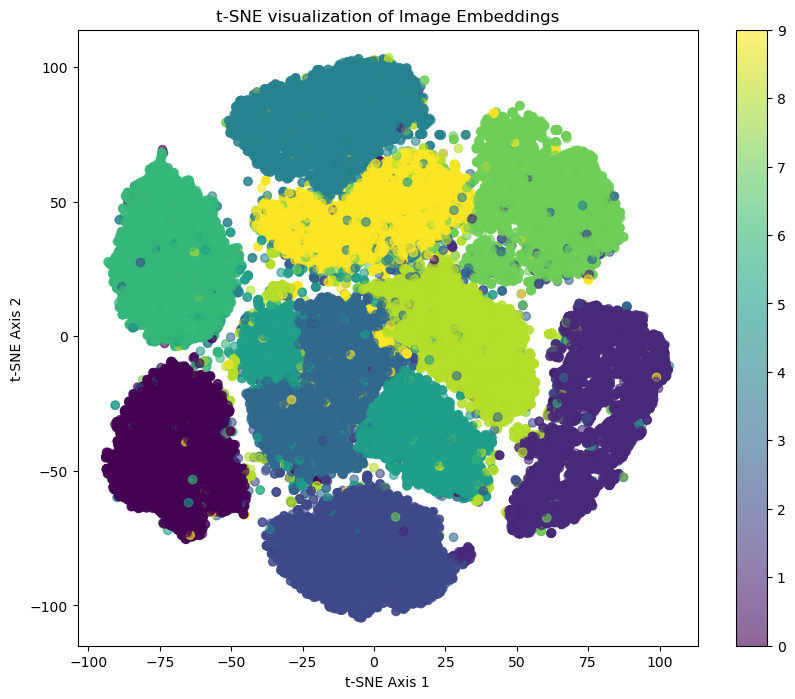

In [20]:
image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)


combined_embeddings = np.concatenate([image_embeddings, audio_embeddings],axis=1)

tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(image_embeddings)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of Image Embeddings')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.show()

1875/1875 [==============================] - 20s 11ms/step


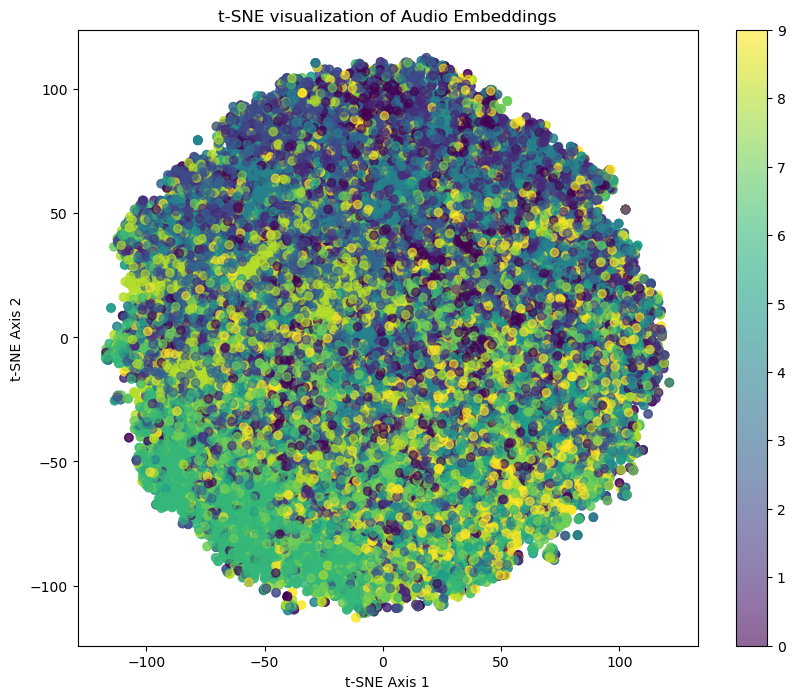

In [21]:
image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)


combined_embeddings = np.concatenate([image_embeddings, audio_embeddings],axis=1)


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(audio_embeddings)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of Audio Embeddings')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.show()

1875/1875 [==============================] - 16s 9ms/step


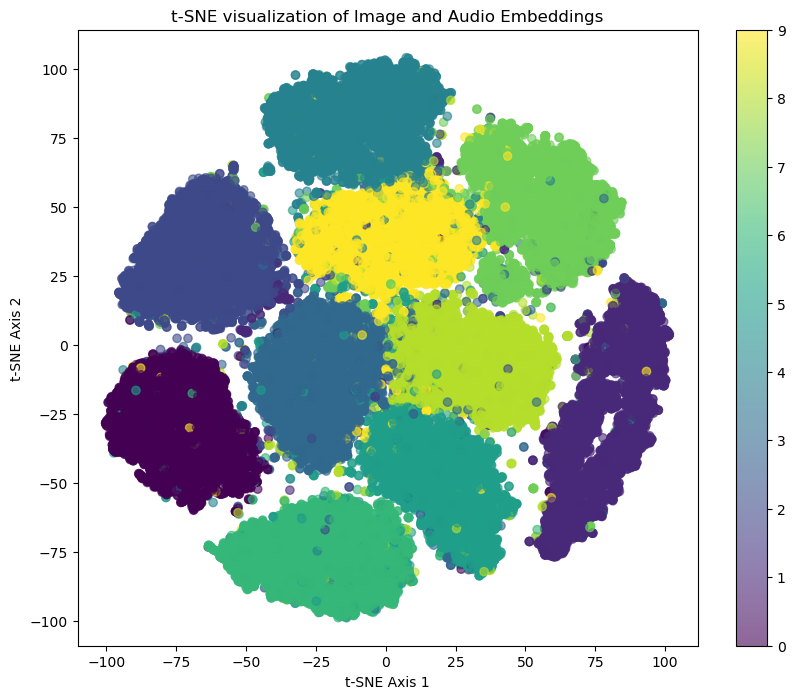

In [22]:
image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)

combined_embeddings = np.concatenate([image_embeddings, audio_embeddings],axis=1)


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(combined_embeddings)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of Image and Audio Embeddings')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.show()

1875/1875 [==============================] - 18s 10ms/step


C:\Users\ritha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


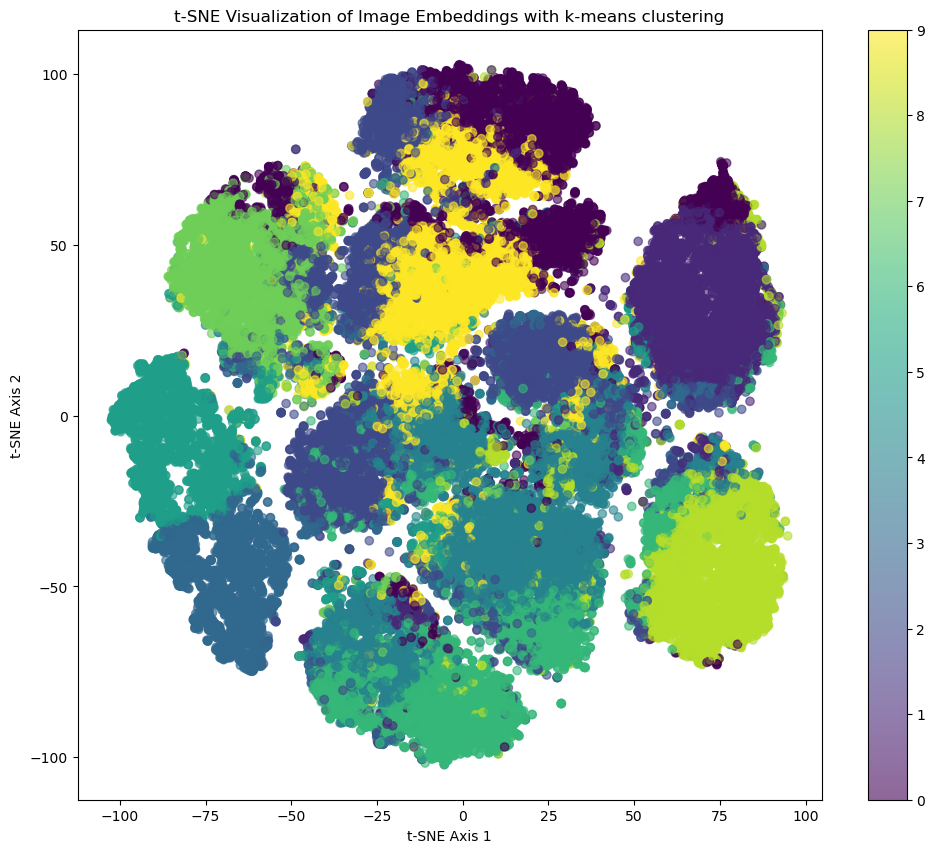

Adjusted Rand Index for Image Embeddings: 0.34161910263873646


In [24]:
image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)


def cluster_and_visualize_combined(image_embeddings, true_labels):
    
   
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(image_embeddings)

    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(image_embeddings)

    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE Visualization of Image Embeddings with k-means clustering')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

    
    ari = adjusted_rand_score(true_labels, cluster_labels)
    print(f'Adjusted Rand Index for Image Embeddings: {ari}')

cluster_and_visualize_combined(image_embeddings, y_train_labels)


1875/1875 [==============================] - 14s 7ms/step


C:\Users\ritha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


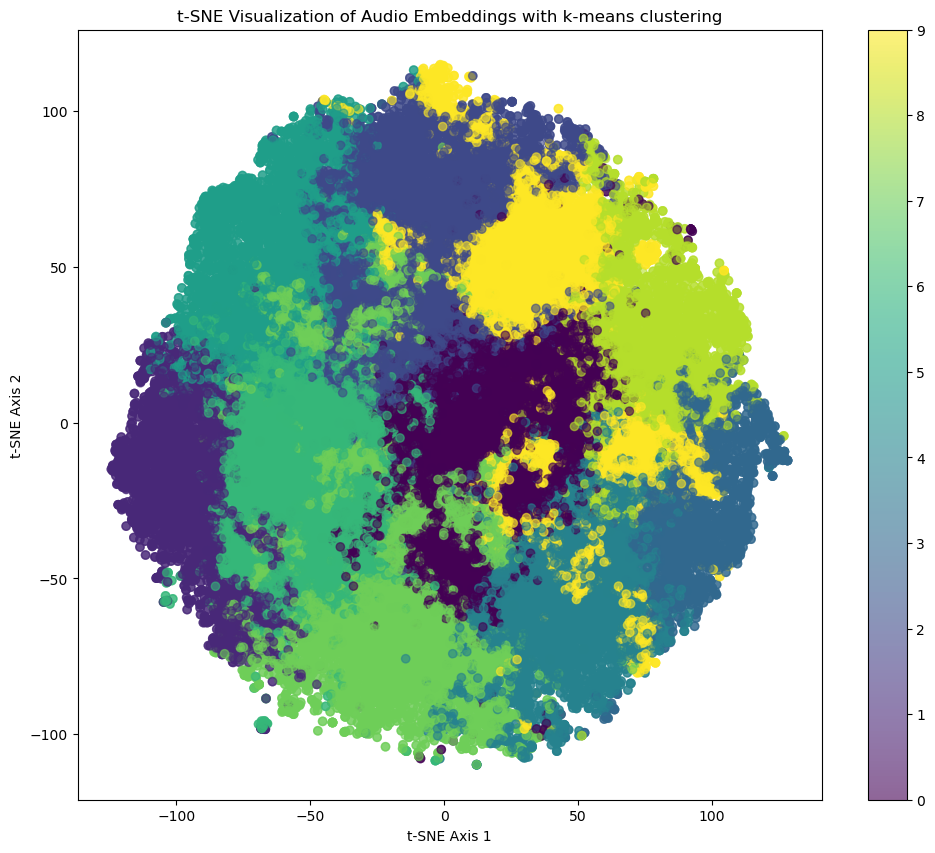

Adjusted Rand Index for  Audio Embeddings: 0.04295852331934464


In [25]:
image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)


def cluster_and_visualize_combined_audio(audio_embeddings, true_labels):
    
    
    
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict( audio_embeddings)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform( audio_embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE Visualization of Audio Embeddings with k-means clustering')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

    ari = adjusted_rand_score(true_labels, cluster_labels)
    print(f'Adjusted Rand Index for  Audio Embeddings: {ari}')

cluster_and_visualize_combined_audio(audio_embeddings, y_train_labels)


1875/1875 [==============================] - 13s 7ms/step


C:\Users\ritha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


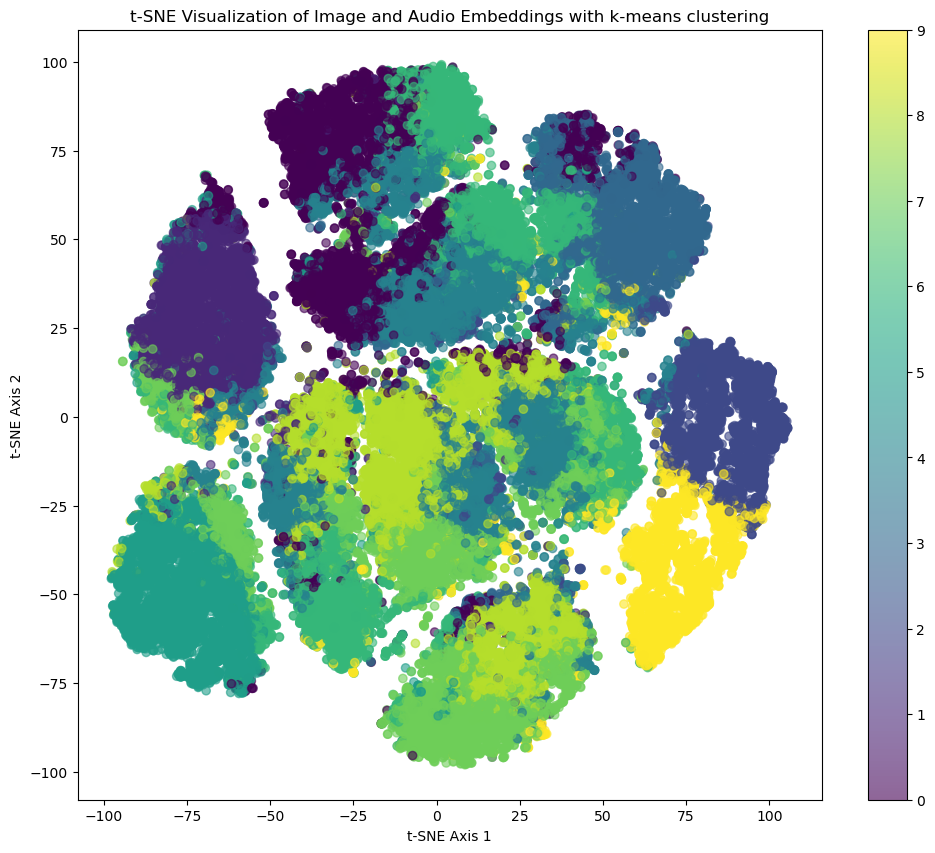

Adjusted Rand Index for Combined Embeddings: 0.29803518022153686


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, confusion_matrix


image_encoder = create_image_encoder()
audio_encoder = create_audio_encoder()

image_embeddings = image_encoder.predict(x_train_wr, batch_size=32)
audio_embeddings = audio_encoder.predict(x_train_sp, batch_size=32)

combined_embeddings = np.concatenate([image_embeddings, audio_embeddings],axis=1)

def cluster_and_visualize_combined_audio(audio_embeddings, true_labels):
   
    
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_embeddings)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(combined_embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE Visualization of Image and Audio Embeddings with k-means clustering')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.show()

    ari = adjusted_rand_score(true_labels, cluster_labels)
    print(f'Adjusted Rand Index for Combined Embeddings: {ari}')
    
    cm = confusion_matrix(true_labels, cluster_labels)
    cm_df = pd.DataFrame(cm, index=[f'Actual Class {i}' for i in range(0, 10)],
                         columns=[f'Predicted Cluster {i}' for i in range(0, 10)])
    return cm_df

df = cluster_and_visualize_combined_audio(audio_embeddings, y_train_labels)


In [39]:
df

,Predicted Cluster 0,Predicted Cluster 1,Predicted Cluster 2,Predicted Cluster 3,Predicted Cluster 4,Predicted Cluster 5,Predicted Cluster 6,Predicted Cluster 7,Predicted Cluster 8,Predicted Cluster 9
Actual Class 0,20,66,0,0,143,4519,232,774,160,9
Actual Class 1,0,5,3430,5,128,0,11,9,18,3136
Actual Class 2,126,69,38,132,280,103,213,2951,1962,84
Actual Class 3,62,9,79,134,1215,32,130,1555,2866,49
Actual Class 4,2885,95,19,32,1126,19,1534,105,6,21
Actual Class 5,250,106,20,17,1003,123,1921,514,1412,55
Actual Class 6,278,4189,32,0,426,134,141,500,15,203
Actual Class 7,591,0,75,3858,556,13,969,33,63,107
Actual Class 8,168,34,24,7,1846,86,1162,1160,1187,177
Actual Class 9,2182,3,47,147,2154,57,1228,31,64,36
